# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV847"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv847')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv847/lv847-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 15:53:52,189 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
1895,REACTOME_AMYLOIDS,847,0.760653,0.000223,0.002170
1896,REACTOME_MEIOTIC_RECOMBINATION,847,0.782196,0.000028,0.000360
1897,REACTOME_RNA_POL_I_TRANSCRIPTION,847,0.747793,0.000045,0.000556
1898,KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS,847,0.735029,0.000013,0.000186


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP057878, SRP037722, SRP009373, SRP007461, SRP058841, SRP009862, SRP047476, SRP048825, SRP036848, SRP003672, SRP034158, SRP035419, SRP018719, SRP014542, SRP002789, SRP041100, SRP061888, SRP063493, SRP042286, SRP021214, SRP033369, SRP045501, SRP045318, SRP034543, SRP061522, SRP023233, SRP041255, SRP055569, SRP042937, SRP050333, SRP052229, SRP061880, SRP065282, SRP053402, SRP042161, SRP002605, SRP058387, SRP050223, SRP010679, SRP048820, SRP059775, SRP021072, SRP020470, SRP047065, SRP028912, SRP063620, SRP045214, SRP043188, SRP019807, SRP037762, SRP057500, SRP012461, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (50 != 52)
  warnings.warn(


In [19]:
lv_data.shape

(3602, 76)

In [20]:
lv_data.head()

3' linker cell line     cell type  \
project   run                                                 
SRP057878 SRR2005810  SOLID Reverse      HeLa           NaN   
          SRR2005809  SOLID Reverse      HeLa           NaN   
SRP037722 SRR1168261  SOLID Reverse       NaN    HeLa cells   
          SRR1168262        NEB+Ext       NaN    HeLa cells   
          SRR1168264        NEB+Ext       NaN  Jurkat cells   

                               sample group tissue fraction gender  \
project   run                                                        
SRP057878 SRR2005810                    NaN    NaN      NaN    NaN   
          SRR2005809                    NaN    NaN      NaN    NaN   
SRP037722 SRR1168261        No d(A) priming    NaN      NaN    NaN   
          SRR1168262  Cap analog Luciferase    NaN      NaN    NaN   
          SRR1168264       Polysome Control    NaN      NaN    NaN   

                     enrichment type molecule subtype treatment  ...  \
project   run                                                    ...   
SRP057878 SRR2005810             NaN              NaN       NaN  ...   
          SRR2005809             NaN              NaN       NaN  ...   
SRP037722 SRR1168261             NaN              NaN       NaN  ...   
          SRR1168262             NaN              NaN       NaN  ...   
          SRR1168264             NaN              NaN       NaN  ...   

                     infection with barcode differentiation time  \
project   run                                                      
SRP057878 SRR2005810            NaN     NaN                  NaN   
          SRR2005809            NaN     NaN                  NaN   
SRP037722 SRR1168261            NaN     NaN                  NaN   
          SRR1168262            NaN     NaN                  NaN   
          SRR1168264            NaN     NaN                  NaN   

                     differentiation stage batch cancer type  \
project   run                                                  
SRP057878 SRR2005810                   NaN   NaN         NaN   
          SRR2005809                   NaN   NaN         NaN   
SRP037722 SRR1168261                   NaN   NaN         NaN   
          SRR1168262                   NaN   NaN         NaN   
          SRR1168264                   NaN   NaN         NaN   

                     mutational subclass  day patient code name     LV847  
project   run                                                              
SRP057878 SRR2005810                 NaN  NaN               NaN  5.595020  
          SRR2005809                 NaN  NaN               NaN  5.571689  
SRP037722 SRR1168261                 NaN  NaN               NaN  2.530109  
          SRR1168262                 NaN  NaN               NaN -0.498960  
          SRR1168264                 NaN  NaN               NaN -0.341162  

[5 rows x 76 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

3' linker              2.594633
sample group           0.780985
cell line              0.086047
fraction               0.029972
rna polyadenylation    0.014432
chromosome             0.013910
rna                    0.013910
infected with          0.013103
protocol               0.012040
cell type              0.011718
ploidy                 0.009100
gender                 0.008233
transfected with       0.008093
time point             0.008093
extract_protocol       0.007623
library                0.007016
passages               0.006578
agent                  0.005781
rna purification       0.005781
passage                0.005527
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type    0.011718
tissue       0.003302
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "cell line",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type    tissue cell line     LV847
project   run                                                               
SRP057878 SRR2005810                       NaN       NaN      HeLa  5.595020
          SRR2005809                       NaN       NaN      HeLa  5.571689
SRP037722 SRR1168261                HeLa cells       NaN       NaN  2.530109
          SRR1168263                HeLa cells       NaN       NaN  2.412951
          SRR1168282                HeLa cells       NaN       NaN  1.196163
          SRR1168281                HeLa cells       NaN       NaN  1.129245
          SRR1168280                HeLa cells       NaN       NaN  1.123416
          SRR1168283                HeLa cells       NaN       NaN  0.977178
          SRR1168277                HeLa cells       NaN       NaN  0.932063
          SRR1168267              Jurkat cells       NaN       NaN  0.757429
SRP009373 SRR364679                       CD19     blood       NaN  0.710225
          SRR384963                       CD19     blood       NaN  0.689603
SRP058841 SRR2044123                       NaN       NaN   HEK293T  0.652469
SRP037722 SRR1168266              Jurkat cells       NaN       NaN  0.557533
          SRR1168284                HeLa cells       NaN       NaN  0.541745
SRP058841 SRR2044122                       NaN       NaN   HEK293T  0.501096
          SRR2044115                       NaN       NaN   HEK293T  0.432563
SRP047476 SRR1585552  Lymphoblastoid Cell Line       NaN   GM19222  0.377049
SRP058841 SRR2044124                       NaN       NaN   HEK293T  0.365581
SRP047476 SRR1585501  Lymphoblastoid Cell Line       NaN   GM18522  0.361861
          SRR1585494  Lymphoblastoid Cell Line       NaN   GM18508  0.356202
SRP058841 SRR2044125                       NaN       NaN   HEK293T  0.352771
SRP048825 SRR2086029                       NaN       NaN        H1  0.336993
SRP036848 SRR1164800                       NaN  prostate       NaN  0.334560
SRP009373 SRR364680                       CD34     blood       NaN  0.326702

In [26]:
# what is there in these projects?
lv_data.loc[["SRP057878"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

3' linker cell line     LV847
project   run                                          
SRP057878 SRR2005810  SOLID Reverse      HeLa  5.595020
          SRR2005809  SOLID Reverse      HeLa  5.571689

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "cell line"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV847
project   run                                           
SRP057878 SRR2005810                      HeLa  5.595020
          SRR2005809                      HeLa  5.571689
SRP037722 SRR1168261                HeLa cells  2.530109
          SRR1168263                HeLa cells  2.412951
          SRR1168282                HeLa cells  1.196163
          SRR1168281                HeLa cells  1.129245
          SRR1168280                HeLa cells  1.123416
          SRR1168283                HeLa cells  0.977178
          SRR1168277                HeLa cells  0.932063
          SRR1168267              Jurkat cells  0.757429
SRP009373 SRR364679                       CD19  0.710225
          SRR384963                       CD19  0.689603
SRP058841 SRR2044123                   HEK293T  0.652469
SRP037722 SRR1168266              Jurkat cells  0.557533
          SRR1168284                HeLa cells  0.541745
SRP058841 SRR2044122                   HEK293T  0.501096
          SRR2044115                   HEK293T  0.432563
SRP047476 SRR1585552  Lymphoblastoid Cell Line  0.377049
SRP058841 SRR2044124                   HEK293T  0.365581
SRP047476 SRR1585501  Lymphoblastoid Cell Line  0.361861

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "HeLa": "HeLa (cervical carcinoma cell line)",
            "HeLa cells": "HeLa (cervical carcinoma cell line)",
            "HeLa (Human cervical carcinoma cell line)": "HeLa (cervical carcinoma cell line)",
        }
    }
)

In [34]:
# add also tissue information to these projects
_srp_code = "SRP009373"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: lv_data.loc[(_srp_code, x.name), "cell type"]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-9bb31b5fb46a>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['HeLa (cervical carcinoma cell line)',
 'Jurkat cells',
 'CD19 (blood)',
 'HEK293T',
 'Lymphoblastoid Cell Line']

## Plot

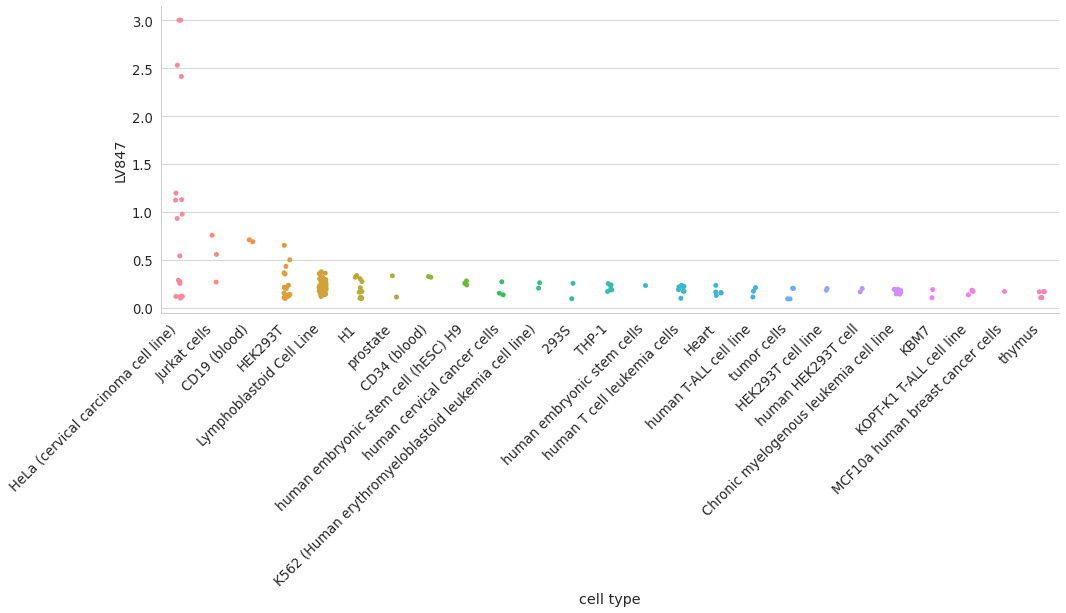

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("CD19")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP009373"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)